### Preliminaries

This example shows both the use of individual transformers and the `TimeSeriesFeatures` convenience class that wraps multiple transformers. Both methods are compatible with Scikit-Learn `Pipeline` objects.

It uses the Macrodata dataset from `Statsmodels`, which includes quarterly US Macroeconomic Data from 1950 through 2009.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.datasets
from sklearn.linear_model import LinearRegression, Lasso, PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from steps.forward import ForwardSelector

from tsfeast.transformers import DateTimeFeatures, InteractionFeatures, LagFeatures
from tsfeast.tsfeatures import TimeSeriesFeatures
from tsfeast.funcs import get_datetime_features
from tsfeast.utils import plot_diag
from tsfeast.models import ARMARegressor

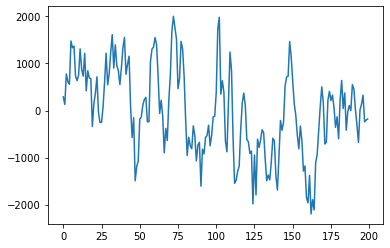

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ar = arma_generate_sample(ar=[1, -.85], ma=[1], nsample=200, scale=500)
plt.plot(ar)

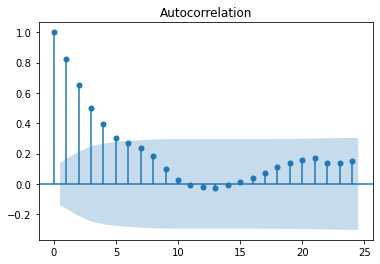

In [3]:
plot_acf(ar)
plt.show()

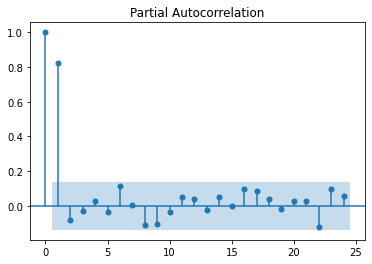

In [4]:
plot_pacf(ar)
plt.show()

In [5]:
def make_dummy_data(n=200):
    n_lags = 2
    coefs = {'ar': [1, -0.85], 'ma': [1, 0], 'trend': 3.2, 'bdays_in_month': 231, 'marketing': 0.002}
    rng = np.random.default_rng(seed=42)
    
    sales = pd.DataFrame({
        'date': pd.date_range(end='2020-08-31', periods=n, freq='M'),
        'sales_base': rng.poisson(1000, n),
        'sales_ar': arma_generate_sample(ar=coefs['ar'], ma=coefs['ma'], nsample=n, scale=100),
        'sales_trend': [x * coefs['trend'] + rng.poisson(300) for x in range(1, n+1)],
    })
    
    sales = sales.join(get_datetime_features(sales['date'])[['bdays_in_month', 'quarter']])
    sales['sales_per_day'] = sales['bdays_in_month'] * coefs['bdays_in_month'] + rng.poisson(100, n)
    
    sales['mkt_base'] = rng.normal(1e6, 1e4, n)
    sales['mkt_trend'] = np.array([x * 5e3 for x in range(1, n+1)]) + rng.poisson(100)
    sales['mkt_season'] = np.where(sales['quarter'] == 3, sales['mkt_base'] * .35, 0)
    sales['mkt_total'] = sales.loc[:, 'mkt_base': 'mkt_season'].sum(1) + rng.poisson(100, n)
    sales['sales_mkting'] = sales['mkt_total'].shift(n_lags) * coefs['marketing']
    
    final = pd.DataFrame({
        'y': sales[['sales_base', 'sales_ar', 'sales_trend', 'sales_per_day', 'sales_mkting']].sum(1).astype(int),
        'date': sales['date'],
        'marketing': sales['mkt_total'],
        'x2': rng.random(n),
        'x3': rng.normal(loc=320, scale=4, size=n)
    })
    return sales.dropna(), final.iloc[n_lags:, :]

In [6]:
comps, data = make_dummy_data()

In [7]:
comps.head(15)

,date,sales_base,sales_ar,sales_trend,bdays_in_month,quarter,sales_per_day,mkt_base,mkt_trend,mkt_season,mkt_total,sales_mkting
2,2004-03-31,1025,-146.708461,320.6,23,1,5402,9.989085e+05,15102.0,0.000000,1.014116e+06,1995.736292
3,2004-04-30,959,-40.012963,284.8,22,2,5171,9.974712e+05,20102.0,0.000000,1.017662e+06,2038.716606
4,2004-05-31,988,71.506485,331.0,20,2,4722,1.005623e+06,25102.0,0.000000,1.030818e+06,2028.231097
5,2004-06-30,1013,-57.525202,323.2,22,2,5176,9.870812e+05,30102.0,0.000000,1.017270e+06,2035.324371
6,2004-07-31,995,-3.013927,359.4,21,3,4948,1.003526e+06,35102.0,351234.195214,1.389972e+06,2061.635457
7,2004-08-31,1005,105.249315,329.6,22,3,5190,1.019130e+06,40102.0,356695.341827,1.416020e+06,2034.540355
8,2004-09-30,1034,-54.327985,336.8,21,3,4971,1.004662e+06,45102.0,351631.621818,1.401493e+06,2779.944935
9,2004-10-31,1025,53.623836,311.0,20,4,4735,9.962379e+05,50102.0,0.000000,1.046449e+06,2832.039780
10,2004-11-30,1027,108.537769,330.2,20,4,4713,9.949289e+05,55102.0,0.000000,1.050127e+06,2802.986797
11,2004-12-31,997,232.446159,314.4,21,4,4940,9.958966e+05,60102.0,0.000000,1.056090e+06,2092.897758


Column: date


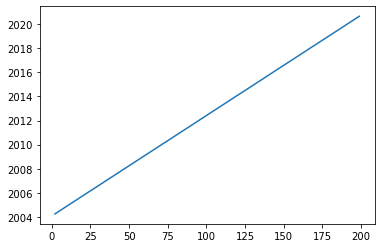

Column: sales_base


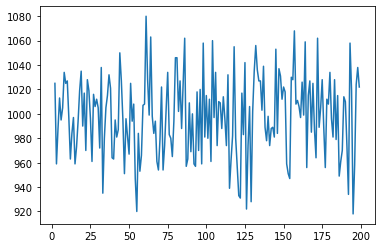

Column: sales_ar


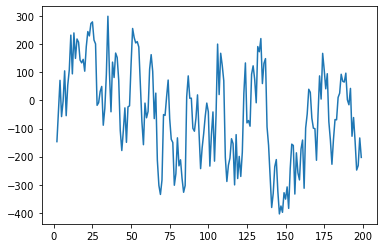

Column: sales_trend


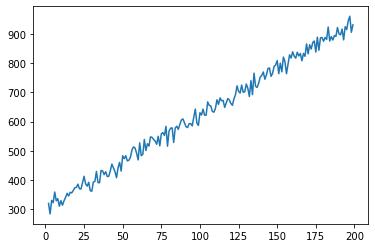

Column: bdays_in_month


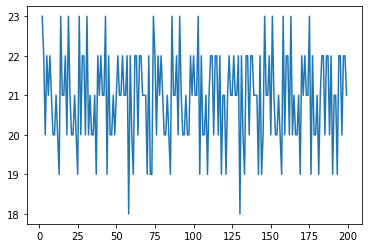

Column: quarter


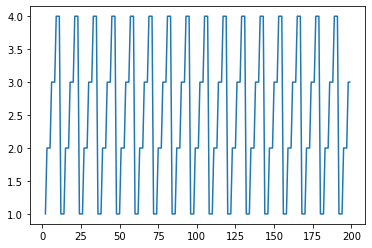

Column: sales_per_day


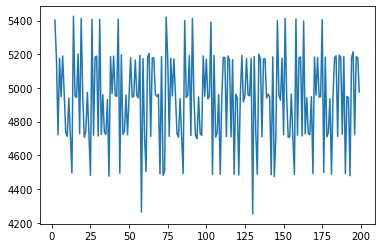

Column: mkt_base


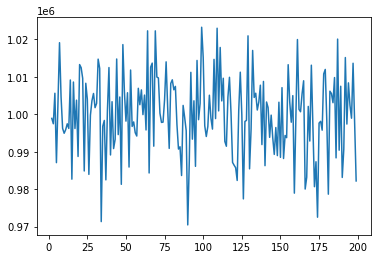

Column: mkt_trend


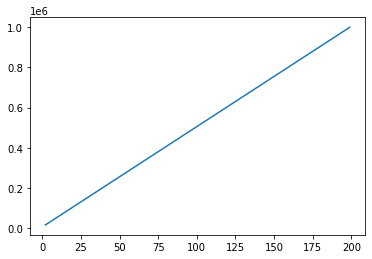

Column: mkt_season


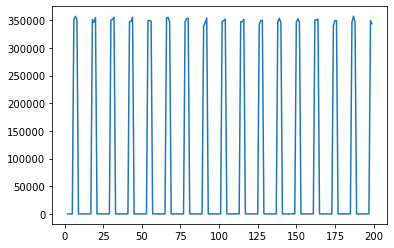

Column: mkt_total


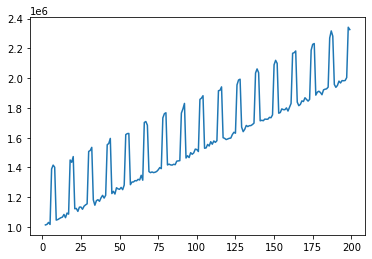

Column: sales_mkting


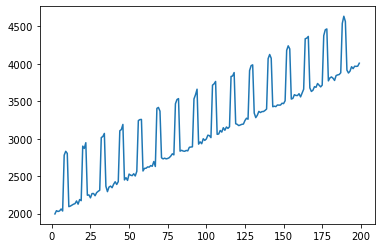

In [8]:
for col in comps.columns:
    print(f'Column: {col}')
    plt.plot(comps[col])
    plt.show()

In [9]:
data.head()

,y,date,marketing,x2,x3
2,8596,2004-03-31,1.014116e+06,0.855475,316.823826
3,8413,2004-04-30,1.017662e+06,0.389889,315.601367
4,8140,2004-05-31,1.030818e+06,0.530723,320.937193
5,8489,2004-06-30,1.017270e+06,0.976527,320.603686
6,8361,2004-07-31,1.389972e+06,0.186483,322.317128


Column: y


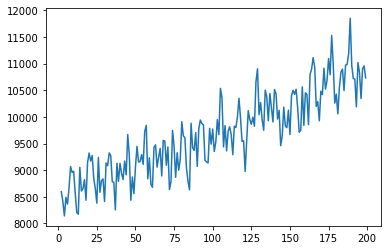

Column: date


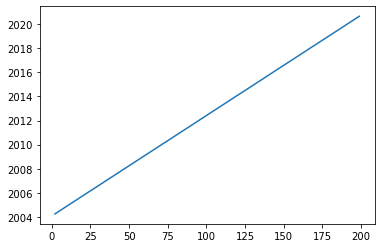

Column: marketing


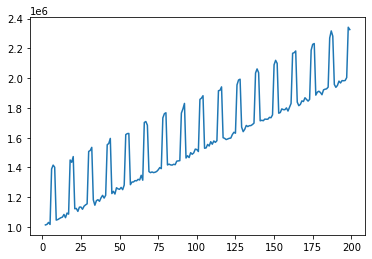

Column: x2


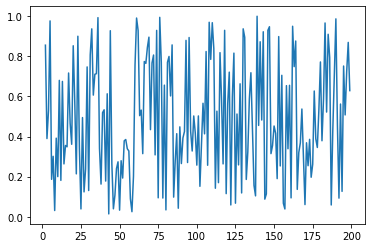

Column: x3


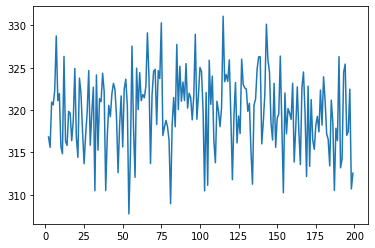

In [10]:
for col in data.columns:
    print(f'Column: {col}')
    plt.plot(data[col])
    plt.show()

The only pre-processing necessary is to combined the separate `year` and `quarter` columns into a single `date` column:

In [11]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
x_train, x_test = X.iloc[:-40, :], X.iloc[-40:, :]
y_train, y_test = y.iloc[:-40], y.iloc[-40:]

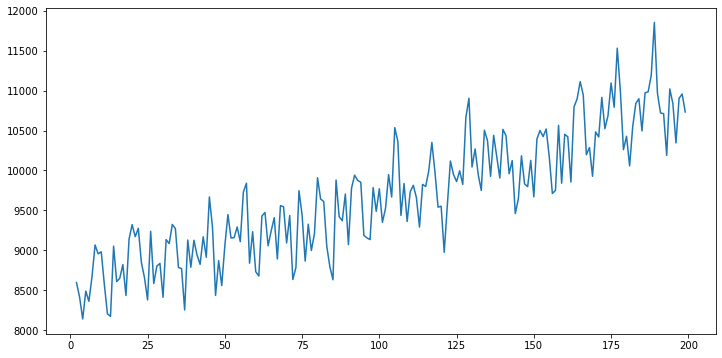

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(y)
plt.show()

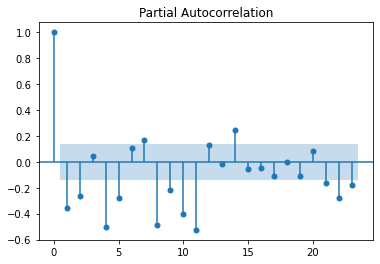

In [13]:
plot_pacf(y.diff().dropna())
plt.show()

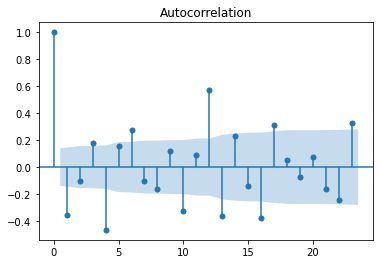

In [14]:
plot_acf(y.diff().dropna())
plt.show()

### Individual Transformers

#### Generate DateTime Features

In [15]:
dt = DateTimeFeatures(date_col='date')
dt.fit_transform(X, y)

,year,quarter,month,days_in_month,bdays_in_month,leap_year
2,2004,1,3,31,23,1
3,2004,2,4,30,22,1
4,2004,2,5,31,20,1
5,2004,2,6,30,22,1
6,2004,3,7,31,21,1
...,...,...,...,...,...,...
195,2020,2,4,30,22,1
196,2020,2,5,31,20,1
197,2020,2,6,30,22,1
198,2020,3,7,31,22,1


#### Generate Interaction Features

In [16]:
feat = LagFeatures(n_lags=4)
feat.fit_transform(X.iloc[:, 1:], y)

,marketing_lag_1,x2_lag_1,x3_lag_1,marketing_lag_2,x2_lag_2,x3_lag_2,marketing_lag_3,x2_lag_3,x3_lag_3,marketing_lag_4,x2_lag_4,x3_lag_4
2,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
3,1.014116e+06,0.855475,316.823826,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
4,1.017662e+06,0.389889,315.601367,1.014116e+06,0.855475,316.823826,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
5,1.030818e+06,0.530723,320.937193,1.017662e+06,0.389889,315.601367,1.014116e+06,0.855475,316.823826,0.000000e+00,0.000000,0.000000
6,1.017270e+06,0.976527,320.603686,1.030818e+06,0.530723,320.937193,1.017662e+06,0.389889,315.601367,1.014116e+06,0.855475,316.823826
...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.983600e+06,0.126564,325.427053,1.967604e+06,0.562009,324.439879,1.980367e+06,0.092785,314.234597,1.950874e+06,0.458376,313.188886
196,1.982571e+06,0.751520,317.020068,1.983600e+06,0.126564,325.427053,1.967604e+06,0.562009,324.439879,1.980367e+06,0.092785,314.234597
197,1.984145e+06,0.507677,317.471657,1.982571e+06,0.751520,317.020068,1.983600e+06,0.126564,325.427053,1.967604e+06,0.562009,324.439879
198,2.003825e+06,0.723431,322.464942,1.984145e+06,0.507677,317.471657,1.982571e+06,0.751520,317.020068,1.983600e+06,0.126564,325.427053


### TimeSeriesFeatures Class


In [17]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=False,
    polynomial=3
)
features = feat.fit_transform(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/tsfeast/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [18]:
features.head()

,trend,original__marketing,original__x2,original__x3,datetime__year,datetime__quarter,datetime__month,datetime__days_in_month,datetime__bdays_in_month,datetime__leap_year,...,features__lags__x3_lag_3,features__lags__marketing_lag_4,features__lags__x2_lag_4,features__lags__x3_lag_4,features__polynomial__marketing^2,features__polynomial__x2^2,features__polynomial__x3^2,features__polynomial__marketing^3,features__polynomial__x2^3,features__polynomial__x3^3
0,1.0,1.014116e+06,0.855475,316.823826,2004.0,1.0,3.0,31.0,23.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,1.028430e+12,0.731838,100377.336616,1.042947e+18,0.626069,3.180193e+07
1,2.0,1.017662e+06,0.389889,315.601367,2004.0,2.0,4.0,30.0,22.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,1.035636e+12,0.152014,99604.222610,1.053928e+18,0.059269,3.143523e+07
2,3.0,1.030818e+06,0.530723,320.937193,2004.0,2.0,5.0,31.0,20.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,1.062585e+12,0.281667,103000.682134,1.095332e+18,0.149487,3.305675e+07
3,4.0,1.017270e+06,0.976527,320.603686,2004.0,2.0,6.0,30.0,22.0,1.0,...,316.823826,0.000000e+00,0.000000,0.000000,1.034839e+12,0.953605,102786.723546,1.052710e+18,0.931221,3.295380e+07
4,5.0,1.389972e+06,0.186483,322.317128,2004.0,3.0,7.0,31.0,21.0,1.0,...,315.601367,1.014116e+06,0.855475,316.823826,1.932023e+12,0.034776,103888.330928,2.685459e+18,0.006485,3.348499e+07


In [19]:
[x for x in features.columns]

['trend',
 'original__marketing',
 'original__x2',
 'original__x3',
 'datetime__year',
 'datetime__quarter',
 'datetime__month',
 'datetime__days_in_month',
 'datetime__bdays_in_month',
 'datetime__leap_year',
 'features__lags__marketing_lag_1',
 'features__lags__x2_lag_1',
 'features__lags__x3_lag_1',
 'features__lags__marketing_lag_2',
 'features__lags__x2_lag_2',
 'features__lags__x3_lag_2',
 'features__lags__marketing_lag_3',
 'features__lags__x2_lag_3',
 'features__lags__x3_lag_3',
 'features__lags__marketing_lag_4',
 'features__lags__x2_lag_4',
 'features__lags__x3_lag_4',
 'features__polynomial__marketing^2',
 'features__polynomial__x2^2',
 'features__polynomial__x3^2',
 'features__polynomial__marketing^3',
 'features__polynomial__x2^3',
 'features__polynomial__x3^3']

In [20]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=False
)

pl = Pipeline([
    ('feature_extraction', feat),
    ('scaler', StandardScaler()),
    ('feature_selection', ForwardSelector(metric='bic')),
    ('regression', LinearRegression())
])

pl.fit(x_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tsfeast/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Pipeline(steps=[('feature_extraction',
                 TimeSeriesFeatures(datetime='date', interactions=False, lags=4,
                                    trend='t')),
                ('scaler', StandardScaler()),
                ('feature_selection', ForwardSelector(metric='bic')),
                ('regression', LinearRegression())])

In [21]:
pl.named_steps.feature_extraction.output_features_

,trend,original__marketing,original__x2,original__x3,datetime__year,datetime__quarter,datetime__month,datetime__days_in_month,datetime__bdays_in_month,datetime__leap_year,...,features__lags__x3_lag_1,features__lags__marketing_lag_2,features__lags__x2_lag_2,features__lags__x3_lag_2,features__lags__marketing_lag_3,features__lags__x2_lag_3,features__lags__x3_lag_3,features__lags__marketing_lag_4,features__lags__x2_lag_4,features__lags__x3_lag_4
0,1.0,1.014116e+06,0.855475,316.823826,2004.0,1.0,3.0,31.0,23.0,1.0,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1,2.0,1.017662e+06,0.389889,315.601367,2004.0,2.0,4.0,30.0,22.0,1.0,...,316.823826,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2,3.0,1.030818e+06,0.530723,320.937193,2004.0,2.0,5.0,31.0,20.0,1.0,...,315.601367,1.014116e+06,0.855475,316.823826,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
3,4.0,1.017270e+06,0.976527,320.603686,2004.0,2.0,6.0,30.0,22.0,1.0,...,320.937193,1.017662e+06,0.389889,315.601367,1.014116e+06,0.855475,316.823826,0.000000e+00,0.000000,0.000000
4,5.0,1.389972e+06,0.186483,322.317128,2004.0,3.0,7.0,31.0,21.0,1.0,...,320.603686,1.030818e+06,0.530723,320.937193,1.017662e+06,0.389889,315.601367,1.014116e+06,0.855475,316.823826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,154.0,1.793451e+06,0.705272,322.017779,2016.0,4.0,12.0,31.0,21.0,1.0,...,310.243001,1.764557e+06,0.898375,318.581211,2.099270e+06,0.190045,326.371648,2.119803e+06,0.416162,319.540888
154,155.0,1.788493e+06,0.067156,317.203913,2017.0,1.0,1.0,31.0,20.0,0.0,...,322.017779,1.768959e+06,0.253308,310.243001,1.764557e+06,0.898375,318.581211,2.099270e+06,0.190045,326.371648
155,156.0,1.788067e+06,0.038751,320.170524,2017.0,1.0,2.0,28.0,19.0,0.0,...,317.203913,1.793451e+06,0.705272,322.017779,1.768959e+06,0.253308,310.243001,1.764557e+06,0.898375,318.581211
156,157.0,1.800201e+06,0.653730,319.653181,2017.0,1.0,3.0,31.0,23.0,0.0,...,320.170524,1.788493e+06,0.067156,317.203913,1.793451e+06,0.705272,322.017779,1.768959e+06,0.253308,310.243001


In [22]:
mean_absolute_error(y_train, pl.predict(x_train))

/opt/homebrew/Caskroom/miniforge/base/envs/tsfeast/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


327.67855588384646

In [23]:
mean_absolute_error(y_test, pl.predict(x_test))

/opt/homebrew/Caskroom/miniforge/base/envs/tsfeast/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


210.6052891051297

In [24]:
new_features = pl.named_steps.feature_extraction.feature_names_
mask = pl.named_steps.feature_selection.get_support()
new_features[mask]

Index(['trend', 'datetime__bdays_in_month', 'features__lags__marketing_lag_2',
       'features__lags__x3_lag_2'],
      dtype='object')

/opt/homebrew/Caskroom/miniforge/base/envs/tsfeast/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/opt/homebrew/Caskroom/miniforge/base/envs/tsfeast/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


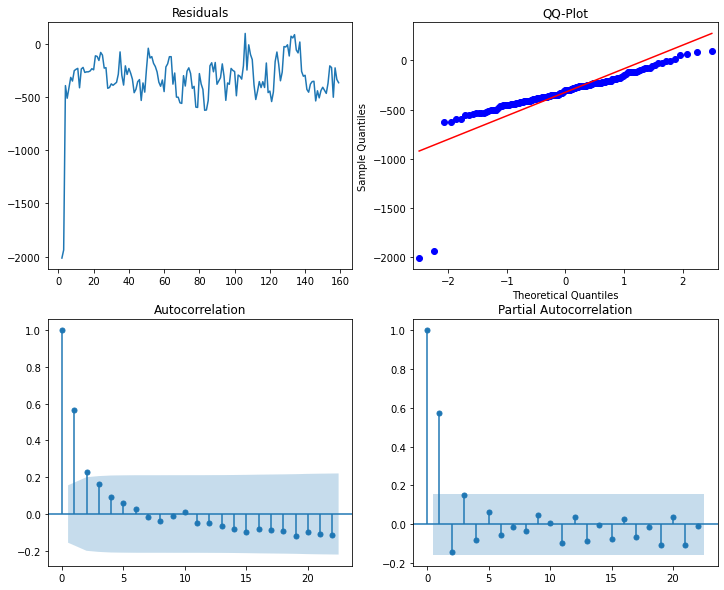

In [25]:
plot_diag(pl, x_train, y_train)

In [26]:
feat = TimeSeriesFeatures(
    datetime='date',
    trend='t',
    lags=4,
    interactions=False
)

mod = ARMARegressor(
    estimator=PoissonRegressor(),
    order=(1,0,0)
)

pl = Pipeline([
    ('feature_extraction', feat),
    ('scaler', StandardScaler()),
    ('feature_selection', ForwardSelector(metric='bic')),
    ('regression', mod)
])

pl.fit(x_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tsfeast/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Pipeline(steps=[('feature_extraction',
                 TimeSeriesFeatures(datetime='date', interactions=False, lags=4,
                                    trend='t')),
                ('scaler', StandardScaler()),
                ('feature_selection', ForwardSelector(metric='bic')),
                ('regression', ARMARegressor(estimator=PoissonRegressor()))])

In [27]:
mean_absolute_error(y_train, pl.predict(x_train))

/opt/homebrew/Caskroom/miniforge/base/envs/tsfeast/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


339.65890964229453

In [28]:
mean_absolute_error(y_test, pl.predict(x_test))

/opt/homebrew/Caskroom/miniforge/base/envs/tsfeast/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


163.3892880612566

In [29]:
plot_diag(pl.named_steps.regression.resid_)

TypeError: plot_diag() got an unexpected keyword argument 'residuals'

In [ ]:
plt.plot(pl.named_steps.regression.fitted_values_ - y_train)

In [ ]:
plt.plot(pl.predict(x_train) - y_train)